# Base Model

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
import scikitplot as skplt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


In [2]:
df_raw = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
df_raw.shape

(284807, 31)

In [3]:
df_raw.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# log transform on Amount
amount_trasnformed = np.log10( df_raw['Amount'].values + 1 )
amount_trasnformed

array([2.17788264, 0.56702637, 2.57939484, ..., 1.83809314, 1.04139269,
       2.33845649])

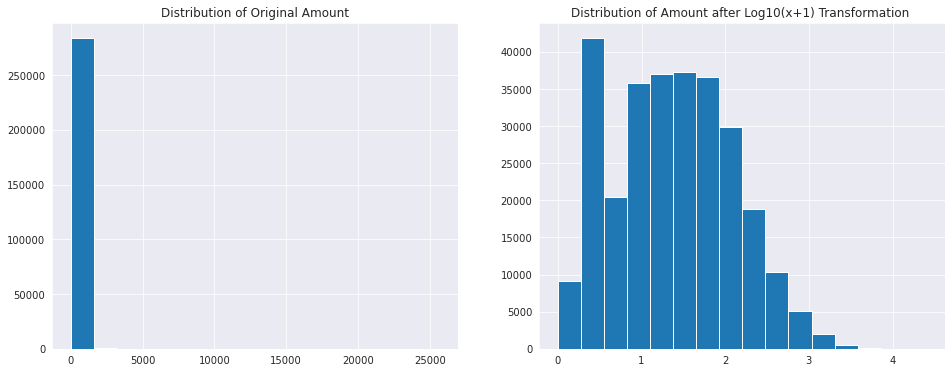

In [5]:
# Plot Log transform compare with original

plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.hist(df_raw['Amount'].values, bins=16)
plt.title('Distribution of Original Amount')

plt.subplot(1,2,2)
plt.hist(amount_trasnformed, bins=16)
plt.title('Distribution of Amount after Log10(x+1) Transformation ')
plt.show()

In [6]:
# make the transformation, time transformed from sec to hour
df_raw['Amount'] = np.log10( df_raw['Amount'].values + 1 )
df_raw['Time'] = df_raw['Time'].values/3600 
df_raw.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,2.177883,0
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0.567026,0
2,0.000278,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,2.579395,0
3,0.000278,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,2.095169,0
4,0.000556,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,1.851197,0


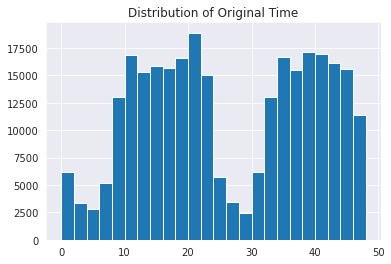

In [7]:
plt.hist(df_raw['Time'].values, bins=24)
plt.title('Distribution of Original Time')
plt.show()

## Split Train Test
stratify target

In [8]:
from sklearn.model_selection import train_test_split

target = 'Class'

# Divide the training data into training (80%) and test (20%)
df_train, df_test = train_test_split(df_raw, train_size=0.8, random_state=42, stratify=df_raw[target])

# Reset the index
df_train, df_test  = df_train.reset_index(drop=True), df_test.reset_index(drop=True)

In [9]:
print(df_train.shape, df_test.shape)

(227845, 31) (56962, 31)


In [10]:
df_train['Class'].value_counts()

0    227451
1       394
Name: Class, dtype: int64

In [11]:
x_train = df_train.drop(target,axis=1)
y_train = df_train[target]
x_test = df_test.drop(target,axis=1)
y_test = df_test[target]

In [12]:
print(x_train.shape, y_train.shape)

(227845, 30) (227845,)


In [13]:
x_train_fraud = x_train[y_train==1]
x_train_fraud.shape

(394, 30)

In [14]:
x_train_fraud_wlabel = df_train[df_train['Class']==1]
x_train_fraud_wlabel.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
942,11.468056,-12.835760,6.574615,-12.788462,8.786257,-10.723121,-2.813536,-14.248847,7.960521,-7.718751,...,2.679490,-0.047335,-0.836982,0.625349,0.125865,0.177624,-0.817680,-0.521030,1.583426,1
1370,2.097500,0.316459,3.809076,-5.615159,6.047445,1.554026,-2.651353,-0.746579,0.055586,-2.678679,...,0.208828,-0.511747,-0.583813,-0.219845,1.474753,0.491192,0.518868,0.402528,0.301030,1
1615,17.316944,-5.267760,2.506719,-5.290925,4.886134,-3.343188,-1.100085,-5.810509,1.726343,-0.749277,...,0.764266,0.473262,0.548482,-0.156850,-0.710187,-0.366423,-1.486766,0.677664,0.322219,1
1664,15.488889,-6.003422,-3.930731,-0.007045,1.714669,3.414667,-2.329583,-1.901512,-2.746111,0.887673,...,1.101671,-0.992494,-0.698259,0.139898,-0.205151,-0.472412,1.775378,-0.104285,2.495419,1
2275,19.519444,-1.512516,1.133139,-1.601052,2.813401,-2.664503,-0.310371,-1.520895,0.852996,-1.496495,...,0.729828,0.485286,0.567005,0.323586,0.040871,0.825814,0.414482,0.267265,2.503940,1


### Random Undersampling & Random Oversampling

In [15]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

ros = RandomOverSampler()
rus = RandomUnderSampler()
x_train_os, y_train_os = ros.fit_sample(x_train, y_train)
x_train_us, y_train_us = rus.fit_sample(x_train, y_train)

print(y_train_os.value_counts())
print(y_train_us.value_counts())

1    227451
0    227451
Name: Class, dtype: int64
1    394
0    394
Name: Class, dtype: int64


## ML Model

In [16]:
def check_performance(y_test, y_pred):
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Precision: ', precision_score(y_test, y_pred))
    print('Recall: ', recall_score(y_test, y_pred))
    print('F1 score: ', f1_score(y_test, y_pred))
    print('ROC AUC score: ',  roc_auc_score(y_test, y_pred))   

In [17]:
def plot_cm(y_test, y_pred, title):
    skplt.metrics.plot_confusion_matrix(y_test, y_pred,figsize=(8,8))
    plt.title('Confusion Matrix ' + title)
    plt.show()

In [ ]:
# # with GPU
# clf_XGBC = XGBClassifier(tree_method='gpu_hist', n_jobs = -1, random_state=42)

# # CPU
# # clf_XGBC = XGBClassifier(n_jobs = -1, random_state=42)
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# parameters = {'learning_rate': [0.01, 0.02],
#               'max_depth': [6, 8, 10],
#               'min_child_weight': [2],
#               'gamma': [0.2, 0.3],
#               'subsample': [0.7],
#               'objective': ['binary:logistic'],
#               'n_estimators': [600, 800],
#               'eval_metric': ['auc']
#              }


# best_score_param_estimators = []
# xgb_gs = GridSearchCV(clf_XGBC ,
#                         parameters,
#                         cv = skf,
#                         scoring='f1',
#                         verbose=1)

# xgb_gs.fit(x_train, y_train)

# best_score_param_estimators.append([xgb_gs.best_score_, xgb_gs.best_params_, xgb_gs.best_estimator_])
# cv_results = pd.DataFrame.from_dict(xgb_gs.cv_results_).sort_values(by=['rank_test_score', 'std_test_score'])

# print(xgb_gs.best_score_)
# print(xgb_gs.best_params_)

# best_score_param_estimators.append([xgb_gs.best_score_, xgb_gs.best_params_, xgb_gs.best_estimator_])

# print(xgb_gs.best_score_)
# print(xgb_gs.best_params_)
# print(best_score_param_estimators[0][2])

# best_estimator = best_score_param_estimators[0][2]
# y_pred = best_estimator.predict(x_test)
# check_performance(y_test, y_pred)

# cm = confusion_matrix(y_test, y_pred)
# cm

# plot_cm(y_test, y_pred, 'None Over/Under Sampling')

**None RUS or ROS**

In [ ]:
# # with GPU
# clf_XGBC = XGBClassifier(tree_method='gpu_hist', n_jobs = -1, random_state=42)

# # CPU
# # clf_XGBC = XGBClassifier(n_jobs = -1, random_state=42)
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# parameters = {'learning_rate': [0.01, 0.02],
#               'max_depth': [6, 7, 8],
#               'min_child_weight': [2, 4],
#               'gamma': [0.2,0.3],
#               'subsample': [0.6, 0.7, 0.8],
#               'objective': ['binary:logistic'],
#               'n_estimators': [600, 700, 800],
#               'eval_metric': ['auc']
#              }


# best_score_param_estimators = []
# xgb_gs_us = GridSearchCV(clf_XGBC ,
#                         parameters,
#                         cv = skf,
#                         scoring='f1',
#                         verbose=1)

# xgb_gs_us.fit(x_train_us, y_train_us)

# best_score_param_estimators.append([xgb_gs_us.best_score_, xgb_gs_us.best_params_, xgb_gs_us.best_estimator_])

# best_score_param_estimators.append([xgb_gs_us.best_score_, xgb_gs_us.best_params_, xgb_gs_us.best_estimator_])

# print(xgb_gs_us.best_score_)
# print(xgb_gs_us.best_params_)
# print(best_score_param_estimators[0][2])


# best_estimator = best_score_param_estimators[0][2]
# y_pred_us = best_estimator.predict(x_test)

# check_performance(y_test, y_pred_us)

# cm_us = confusion_matrix(y_test, y_pred_us)
# cm_us
# plot_cm(y_test, y_pred_us, 'RUS')

In [18]:
# best params after gridsearch
clf_xgb_us = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0.2, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=6, min_child_weight=2,
              monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
              n_estimators=600, n_jobs=-1, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

clf_xgb_us.fit(x_train_us, y_train_us)   
y_pred_us = clf_xgb_us.predict(x_test)

check_performance(y_test, y_pred_us)

Accuracy:  0.9542502018889786
Precision:  0.03382899628252788
Recall:  0.9285714285714286
F1 score:  0.06527977044476328
ROC AUC score:  0.941432942760672


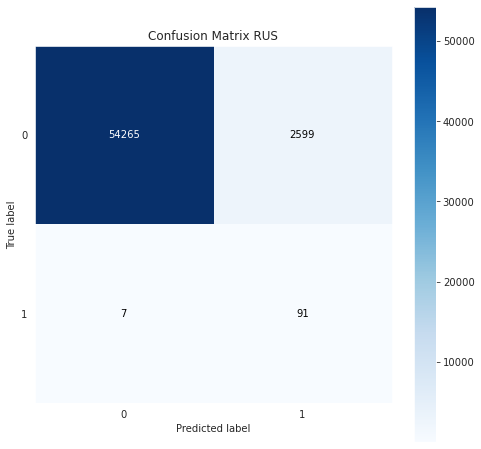

In [19]:
plot_cm(y_test, y_pred_us, 'RUS')

ROS

In [ ]:
# # with GPU
# clf_XGBC = XGBClassifier(tree_method='gpu_hist', n_jobs = -1, random_state=42)

# # CPU
# # clf_XGBC = XGBClassifier(n_jobs = -1, random_state=42)
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# parameters = {'learning_rate': [0.01, 0.02],
#               'max_depth': [6, 8, 10],
#               'min_child_weight': [2],
#               'gamma': [0.2, 0.3],
#               'subsample': [0.7],
#               'objective': ['binary:logistic'],
#               'n_estimators': [600, 800],
#               'eval_metric': ['auc']
#              }


# best_score_param_estimators_os = []
# xgb_gs_os = GridSearchCV(clf_XGBC ,
#                         parameters,
#                         cv = skf,
#                         scoring='f1',
#                         verbose=1)

# xgb_gs_os.fit(x_train_os, y_train_os)

# best_score_param_estimators_os.append([xgb_gs_os.best_score_, xgb_gs_os.best_params_, xgb_gs_os.best_estimator_])
# cv_results_os = pd.DataFrame.from_dict(xgb_gs_os.cv_results_).sort_values(by=['rank_test_score', 'std_test_score'])

# print(xgb_gs_os.best_score_)
# print(xgb_gs_os.best_params_)

# cv_results_os.head(3)


# best_estimator_os = best_score_param_estimators_os[0][2]
# y_pred_os = best_estimator_os.predict(x_test)



# check_performance(y_test, y_pred_os)

# best_estimator_os



# cm_os = confusion_matrix(y_test, y_pred_os)
# cm_os
# plot_cm(y_test, y_pred_os, 'ROS')

In [20]:
# best params after gridsearch
clf_xgb_os = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0.2, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.02, max_delta_step=0,
              max_depth=10, min_child_weight=2, 
              monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
              n_estimators=800, n_jobs=-1, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
clf_xgb_os.fit(x_train_os, y_train_os)


clf_xgb_os.fit(x_train_os, y_train_os)   
y_pred_os = clf_xgb_os.predict(x_test)

check_performance(y_test, y_pred_os)

Accuracy:  0.9994908886626171
Precision:  0.8556701030927835
Recall:  0.8469387755102041
F1 score:  0.8512820512820514
ROC AUC score:  0.923346287023532


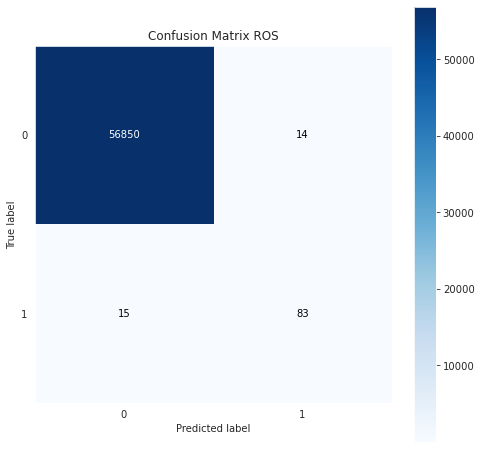

In [21]:
plot_cm(y_test, y_pred_os, 'ROS')